# Dataset Splitting

This notebook loads the locally saved dataset after [NII Files Processing](https://colab.research.google.com/drive/1skyOup7LPY3kJWPREMSkowqNeRgtACx8?usp=sharing) and splits it into training, testing and validation subsets. The result is uploaded to Kaggle for subsequent processing.

In [1]:
# Import required packages
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
import shutil
import matplotlib.pyplot as plt

In [2]:
# Load the image and mask file paths, as well as the number of segments into a Python dict
# 0 - only background, 1 - backgorund and liver, 2 - background, liver and tumor
info = {'filepath': [], 'maskpath': [], 'segments': []}

for i, path in enumerate(Path('liver/images').glob('*')):
    info['filepath'].append(path)
    maskpath = Path('liver_masks') / 'masks' / f'{path.stem}_mask.png'
    info['maskpath'].append(maskpath)
    info['segments'].append(np.array(Image.open(maskpath)).max())


In [3]:
# Convert the dicto into a DataFrame abd Show five random rows
df = pd.DataFrame(info)
df.sample(5)

,filepath,maskpath,segments
8481,liver\images\volume-110_slice_329.jpg,liver_masks\masks\volume-110_slice_329_mask.png,0
56360,liver\images\volume-97_slice_293.jpg,liver_masks\masks\volume-97_slice_293_mask.png,0
30934,liver\images\volume-27_slice_78.jpg,liver_masks\masks\volume-27_slice_78_mask.png,0
56226,liver\images\volume-97_slice_172.jpg,liver_masks\masks\volume-97_slice_172_mask.png,0
40197,liver\images\volume-65_slice_386.jpg,liver_masks\masks\volume-65_slice_386_mask.png,1


In [5]:
len_bg = len(df[df.segments == 0])
len_liver = len(df[df.segments == 1])
len_tumor = len(df[df.segments == 2])

print('Number of background images:', len_bg)
print('Number of liver images:', len_liver)
print('Number of tumor images:', len_tumor)

print(f'Percentage of background images: {(len_bg / len(df)):.2%}')
print(f'Percentage of liver images: {(len_liver / len(df)):.2%}')
print(f'Percentage of tumor images: {(len_tumor / len(df)):.2%}')

Number of background images: 39475
Number of liver images: 11973
Number of tumor images: 7190
Percentage of background images: 67.32%
Percentage of liver images: 20.42%
Percentage of tumor images: 12.26%


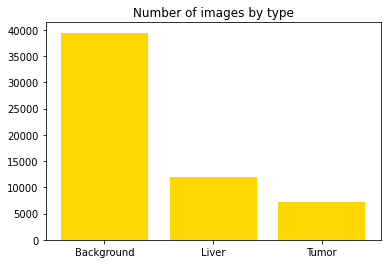

In [6]:
fig, ax = plt.subplots()
ax.bar(('Background', 'Liver', 'Tumor'), (len_bg, len_liver, len_tumor), color='gold')
ax.set_title('Number of images by type')
plt.show()

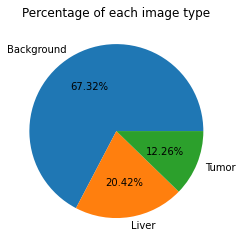

In [7]:
fig, ax = plt.subplots()
ax.pie((len_bg, len_liver, len_tumor), labels=('Background', 'Liver', 'Tumor'), autopct='%.2f%%')
ax.set_title('Percentage of each image type')
plt.show()

In [8]:
# Separate the images into different DataFrames, removing the inbalance between them
dft = df[df.segments == 2] # All Tumor images (7190)
dfl = df[df.segments == 1].sample(len_tumor) # 7190 Liver images (Same as Tumor)
dfb = df[df.segments == 0].sample(len_tumor // 2) # 3595 Background images (half as many as Liver and Tumor ones)
ds = pd.concat([dft, dfl, dfb], ignore_index=True)

In [9]:
print('Total number of selected images:', len(ds))

Total number of selected images: 17975


In [10]:
print('Number of background images:', len(dfb))
print('Number of liver images:', len(dfl))
print('Number of tumor images:', len(dft))

print(f'Percentage of background images: {(len(dfb) / len(ds)):.2%}')
print(f'Percentage of liver images: {(len(dfl) / len(ds)):.2%}')
print(f'Percentage of tumor images: {(len(dft) / len(ds)):.2%}')

Number of background images: 3595
Number of liver images: 7190
Number of tumor images: 7190
Percentage of background images: 20.00%
Percentage of liver images: 40.00%
Percentage of tumor images: 40.00%


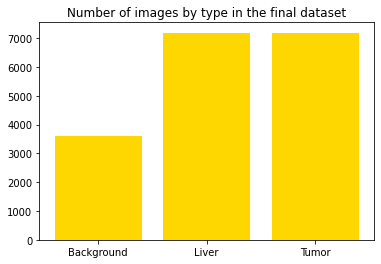

In [51]:
fig, ax = plt.subplots()
ax.bar(('Background', 'Liver', 'Tumor'), (len(dfb), len(dfl), len(dft)), color='gold')
ax.set_title('Number of images by type in the final dataset')
plt.show()

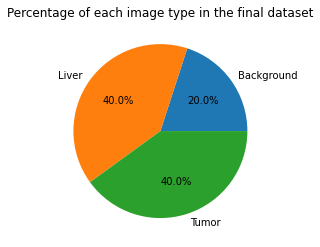

In [44]:
fig, ax = plt.subplots()
ax.pie((len(dfb), len(dfl), len(dft)), labels=('Background', 'Liver', 'Tumor'), autopct='%1.1f%%')
ax.set_title('Percentage of each image type in the final dataset')
plt.show()

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
# Create separate train, test and validation DataFrame 
# for each image type in order to preserve their ratio

# 80% train, 15% val, 5% test
dft_train, dft_val = train_test_split(dft, test_size=.2)
dfc_train, dfc_val = train_test_split(dfl, test_size=.2)
dfb_train, dfb_val = train_test_split(dfb, test_size=.2)

dft_val, dft_test = train_test_split(dft_val, test_size=.25)
dfc_val, dfc_test = train_test_split(dfc_val, test_size=.25)
dfb_val, dfb_test = train_test_split(dfb_val, test_size=.25)

In [68]:
# Setup output folders
root = Path('liver-segmentation')
root.mkdir(exist_ok=True)

train_dir = (root / 'train')
val_dir = (root / 'val')
test_dir = (root / 'test')

train_dir.mkdir(exist_ok=True)
val_dir.mkdir(exist_ok=True)
test_dir.mkdir(exist_ok=True)

In [93]:
from itertools import chain

# Generate the training images and annotations
tr_im = train_dir / 'images'
tr_mask = train_dir / 'masks'

tr_im.mkdir(exist_ok=True)
tr_mask.mkdir(exist_ok=True)

for index, row in chain(dft_train.iterrows(), dfc_train.iterrows(), dfb_train.iterrows()):

    shutil.copy(row['filepath'], tr_im)
    shutil.copy(row['maskpath'], tr_mask)


In [ ]:
# Generate the validation images and annotations
val_im = val_dir / 'images'
val_mask = val_dir / 'masks'

val_im.mkdir(exist_ok=True)
val_mask.mkdir(exist_ok=True)

for index, row in chain(dft_val.iterrows(), dfc_val.iterrows(), dfb_val.iterrows()):

    shutil.copy(row['filepath'], val_im)
    shutil.copy(row['maskpath'], val_mask)

In [ ]:
# Generate the testing images and annotations
test_im = test_dir / 'images'
test_mask = test_dir / 'masks'

test_im.mkdir(exist_ok=True)
test_mask.mkdir(exist_ok=True)

for index, row in chain(dft_test.iterrows(), dfc_test.iterrows(), dfb_test.iterrows()):

    shutil.copy(row['filepath'], test_im)
    shutil.copy(row['maskpath'], test_mask)